# Download Mgnify analysis results

![MGnify](../../assets/figs/mgnify_banner.png)

1. search studies
2. get analyses in a dataframe and save them as `.parquet`
3. compare to local data

In [1]:
# Connection to MGnify API

# this repo is not maintained, or less than jsonapi-requests
# consider a dep change
import os
from jsonapi_client import Session as APISession

# Dataframes and display
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data transformation
from functools import reduce

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline 

# Warning verbosity
import warnings 
warnings.filterwarnings(action="ignore")

import logging
logging.disable(logging.CRITICAL)

## Taxonomy summaries from MGnify studies

In [2]:
TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# local predownloaded MGnify file
ds = {
    'Sola': ['MGYS00006680', 'mgnify_data/SRP237882_taxonomy_abundances_SSU_v5.0.tsv'],
    'OSD2018': ['MGYS00006608', 'mgnify_data/ERP124424_taxonomy_abundances_SSU_v5.0.tsv'],
}

# create timestamped output folder
stamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M')
OUT_FOLDER = os.path.abspath('analysis_' + stamp)

if not os.path.exists(OUT_FOLDER):
    os.makedirs(OUT_FOLDER)
else:
    print(f"Directory {OUT_FOLDER} already exists.")

#### Notes on correspondence
- column names in from the summary table correspond to `relationships.sample.data.id` in analysis table.

In [3]:
# Data download, and save to file
from urllib.request import urlretrieve
import sys
from pathlib import Path

from momics.taxonomy import (
    clean_tax_row,
    fill_taxonomy_placeholders,
    remove_high_taxa,
    prevalence_cutoff,
    normalize_abundance,
    rarefy_table,
)
from momics.utils import load_and_clean

from momics.metadata import (
    # process_collection_date,
    extract_season,
)
from tqdm import tqdm

# Notebooks don't always have a package parent, so avoid relative imports.
# Try direct import first, then add project root to sys.path if needed,
# and finally fall back to loading the module by file path.
try:
    # preferred: import as a top-level package if available
    from scripts.mgnify.mgnify_utils import *
except Exception:
    # attempt to find project root containing 'scripts' folder and add to sys.path
    print('exception')
    root = Path.cwd()
    for _ in range(8):
        if (root / "scripts").exists():
            sys.path.insert(0, str(root))
            break
        if root.parent == root:
            break
        root = root.parent

    from scripts.mgnify.mgnify_utils import *

exception


In [4]:
def fetch_analysis_metadata(analysisId):
    try:
        analysis_meta = pd.read_csv(f'{analysisId}_analysis_meta.csv').reset_index(drop=True)
    except FileNotFoundError:
        print(f"Metadata file not found: Downloading...")

        with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as session:
            analysis_meta = map(lambda r: r.json, session.iterate(f'studies/{analysisId}/analyses'))
            analysis_meta = pd.json_normalize(analysis_meta)

        analysis_meta.to_csv(f'{analysisId}_analysis_meta.csv', index=False)
    return analysis_meta

def fetch_samples_metadata(analysisId):
    try:
        samples_meta = pd.read_csv(f'{analysisId}_samples_meta.csv').reset_index(drop=True)
    except FileNotFoundError:
        print(f"Samples metadata file not found: Downloading...")
        samples_meta = get_mgnify_metadata(analysisId)
        samples_meta.to_csv(f'{analysisId}_samples_meta.csv', index=False)
    return samples_meta

import re


def extract_first_date(x):
    if pd.isna(x):
        return None
    # find the first occurrence of YYYY-MM-DD in the string
    match = re.search(r"\d{4}-\d{2}-\d{2}", str(x))
    return match.group(0) if match else None


def process_collection_date(metadata: pd.DataFrame) -> pd.DataFrame:
    """
    Process the 'collection_date' column in the metadata DataFrame.
    This function converts the 'collection_date' column to datetime format,
    extracts the year, month, and day, and adds them as new columns.
    It also converts the month number to the month name (abbreviated).

    Args:
        metadata (pd.DataFrame): The metadata DataFrame containing the 'collection_date' column.

    Returns:
        pd.DataFrame: The updated metadata DataFrame with new columns for year, month, and day.
    """
    new_columns = []
    # Convert the 'collection_date' column to datetime
    before = len(metadata)
    metadata["collection_date"] = (
        metadata["collection_date"]
        .apply(extract_first_date)
        .pipe(pd.to_datetime, errors="coerce")
        .dt.date
    )
    
    invalid_count = metadata["collection_date"].isna().sum() # Count invalids (NaT)
    metadata = metadata.dropna(subset=["collection_date"]) # Drop them

    print(f"Dropped {invalid_count} rows with invalid or missing collection_date "
        f"({before - len(metadata)} actually removed).")
    # print(metadata['collection_date'].value_counts(dropna=False))
    
    # Extract the year from the 'collection_date' column
    metadata["year"] = metadata["collection_date"].apply(
        lambda x: x.year if x is not None else None
    )
    new_columns.append("year")
    # Extract the month from the 'collection_date' column
    metadata["month"] = metadata["collection_date"].apply(
        lambda x: x.month if x is not None else None
    )

    new_columns.append("month")

    # Convert month to month name
    metadata["month_name"] = metadata["month"].apply(
        lambda x: (
            datetime.strptime(str(x), "%m").strftime("%B")[:3]
            if x is not None
            else None
        )
    )
    new_columns.append("month_name")
    # Extract the day from the 'collection_date' column
    metadata["day"] = metadata["collection_date"].apply(
        lambda x: x.day if x is not None else None
    )
    new_columns.append("day")
    return metadata, new_columns

### Get all samples from the study
- Query MGnify for metadata purposes

In [5]:
analysis_meta_dfs = {}
for k, values in ds.items():
    analysisId = values[0]
    analysis_meta = fetch_analysis_metadata(analysisId)

    analysis_meta_dfs[k] = analysis_meta

# add study tag to each analysis metadata dataframe
for k, df in analysis_meta_dfs.items():
    print(f"Analysis {k} has {df.shape[0]} samples.")
    df['study_tag'] = k

# concatenate all metadata dataframes
analysis_meta = pd.concat(analysis_meta_dfs.values(), ignore_index=True)

Analysis Sola has 283 samples.
Analysis OSD2018 has 62 samples.


In [6]:
analysis_meta.head(1)

,type,id,attributes.accession,attributes.pipeline-version,attributes.experiment-type,attributes.analysis-status,attributes.analysis-summary,attributes.is-private,attributes.last-update,attributes.complete-time,attributes.instrument-platform,attributes.instrument-model,relationships.study.data.id,relationships.study.data.type,relationships.run.data.id,relationships.run.data.type,relationships.sample.data.id,relationships.sample.data.type,study_tag,attributes.mgx-accession
0,analysis-jobs,MGYA00776407,MGYA00776407,5.0,amplicon,completed,"[{'key': 'Submitted nucleotide sequences', 'value': '20364'}, {'key': 'Nucleotide sequences after format-specific filtering', 'value': '17715'}, {'key': 'Nucleotide sequences after length filtering', 'value': '17715'}, {'key': 'Nucleotide sequences after undetermined bases filtering', 'value': '17715'}, {'key': 'Predicted LSU sequences', 'value': '0'}, {'key': 'Predicted SSU sequences', 'value': '12400'}]",False,2024-07-29T08:09:22.442354,2024-07-29T08:09:00,ILLUMINA,Illumina MiSeq,MGYS00006680,studies,SRR10717050,runs,SRS5841512,samples,Sola,NaN


In [14]:
samples_meta_dfs = {}
for k, values in ds.items():
    analysisId = values[0]
    samples_meta = fetch_samples_metadata(analysisId)
    samples_meta_dfs[k] = samples_meta

# add study tag to each analysis metadata dataframe
for k, df in samples_meta_dfs.items():
    print(f"Analysis {k} has {df.shape[0]} samples.")
    df['study_tag'] = k

# concatenate all metadata dataframes
samples_meta = pd.concat(samples_meta_dfs.values(), ignore_index=True)

Analysis Sola has 283 samples.
Analysis OSD2018 has 62 samples.


In [15]:
# samples_meta.head()

In [16]:
# enhance metadata
samples_meta.rename(columns={'collection date': 'collection_date'}, inplace=True)
samples_meta, cols = process_collection_date(samples_meta)
samples_meta, cols = extract_season(samples_meta)

samples_meta['sample_type'] = samples_meta['sample-name'].apply(lambda x: 'euk' if 'Euk' in x else 'prok')

bef = samples_meta.shape[0]
samples_meta = samples_meta[samples_meta['sample_type'].isin(['prok'])].reset_index(drop=True)
after = samples_meta.shape[0]
print(f"Filtered samples to prokaryotes only: {bef} -> {after}")

Dropped 2 rows with invalid or missing collection_date (2 actually removed).
Filtered samples to prokaryotes only: 343 -> 202


In [18]:
# one is eukaryotes, the other is prokaryotes
# samples_meta[samples_meta['collection_date']==pd.to_datetime("2015-05-04").date()]

### Stats on reads identified

Samples not matched to season metadata: 143


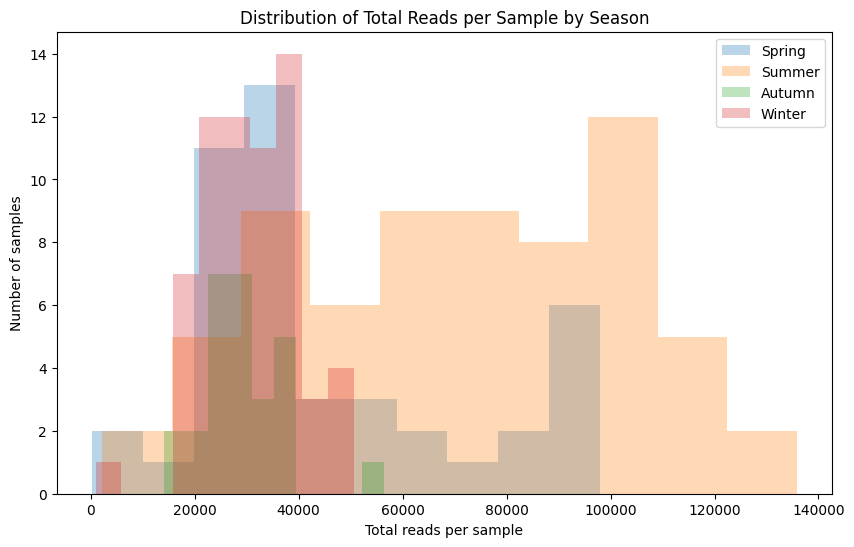

In [19]:
total_dict = plot_season_reads_hist(
    analysis_meta,
    samples_meta,
    name='season_reads_unfiltered.png',
    out_dir=OUT_FOLDER,
    use_robust_save=False,
)

### Filter out samples with little reads

In [20]:
cutoff = 25000

to_drop = []
for season, v in total_dict.items():
    for sample, (total, ratio) in v.items():
        if total > cutoff:
            continue
        to_drop.append(sample)
print(f"Dropping {len(to_drop)} samples with less than {cutoff} reads: {to_drop}")

for sample in to_drop:
    analysis_meta = analysis_meta[analysis_meta['relationships.run.data.id']!=sample]

Dropping 37 samples with less than 25000 reads: ['SRR10717023', 'SRR10716954', 'SRR10716950', 'SRR10716948', 'SRR10717010', 'SRR10717002', 'SRR10717005', 'SRR10716938', 'ERR4674181', 'ERR4674146', 'SRR10716996', 'SRR10716995', 'SRR10716991', 'SRR10716988', 'SRR10716990', 'SRR10716985', 'SRR10716989', 'SRR10716933', 'SRR10716928', 'SRR10717050', 'SRR10717046', 'SRR10716977', 'SRR10716972', 'SRR10716971', 'SRR10716970', 'SRR10716910', 'SRR10716983', 'SRR10716979', 'SRR10716974', 'SRR10716969', 'SRR10716966', 'SRR10716963', 'SRR10716962', 'SRR10716916', 'SRR10716915', 'SRR10716902', 'SRR10716900']


Samples not matched to season metadata: 143


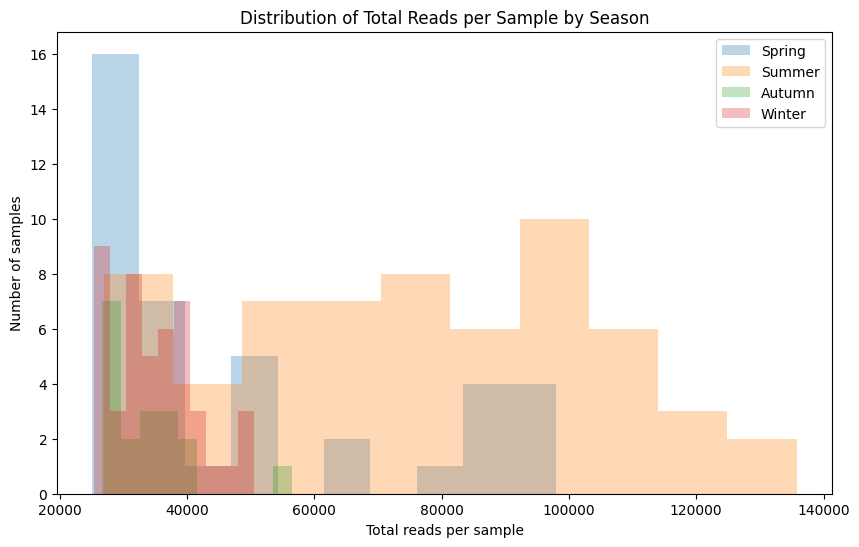

In [21]:
total_dict = plot_season_reads_hist(
    analysis_meta,
    samples_meta,
    name='season_reads_filtered.png',
    out_dir=OUT_FOLDER,
    use_robust_save=False,
)

### Load the Mgnify summary table
- This should be concatenation of all the samples from above

In [22]:
root_folder = os.path.abspath(os.path.join('../../'))
assets_folder = os.path.join(root_folder, 'assets')
data_folder = os.path.join(root_folder, 'data')

In [23]:
def import_taxonomy_summary(folder, path):
    df_tax_summary = pd.read_csv(os.path.join(folder, path), sep='\t')

    df_tax_summary.rename(columns={'#SampleID': 'taxonomy'}, inplace=True)
    df_tax_summary.set_index('taxonomy', inplace=True)
    return df_tax_summary

dfs = {}
for k, values in ds.items():
    path = values[1]
    dfs[k] = import_taxonomy_summary(data_folder, path)


# merge all taxonomy dataframes
from functools import reduce
df_tax_summary = reduce(
    lambda left, right: pd.merge(left, right, on='taxonomy', how='outer'),
    dfs.values()
)
df_tax_summary = df_tax_summary.astype("Int32").fillna(0)

In [24]:
df_tax_summary.head()

,SRR10716830,SRR10716840,SRR10716850,SRR10716860,SRR10716870,SRR10716880,SRR10716890,SRR10716900,SRR10716910,SRR10716920,SRR10716930,SRR10716940,SRR10716950,SRR10716960,SRR10716970,SRR10716980,SRR10716990,SRR10717000,SRR10717010,SRR10717020,SRR10717030,SRR10717040,SRR10717050,SRR10717060,SRR10717070,SRR10717080,SRR10717090,SRR10717100,SRR10716821,SRR10716831,SRR10716841,SRR10716851,SRR10716861,SRR10716871,SRR10716881,SRR10716891,SRR10716901,SRR10716911,SRR10716921,SRR10716931,SRR10716941,SRR10716951,SRR10716961,SRR10716971,SRR10716981,SRR10716991,SRR10717001,SRR10717011,SRR10717021,SRR10717031,SRR10717041,SRR10717051,SRR10717061,SRR10717071,SRR10717081,SRR10717091,SRR10717101,SRR10716822,SRR10716832,SRR10716842,SRR10716852,SRR10716862,SRR10716872,SRR10716882,SRR10716892,SRR10716902,SRR10716912,SRR10716922,SRR10716932,SRR10716942,SRR10716952,SRR10716962,SRR10716972,SRR10716982,SRR10716992,SRR10717002,SRR10717012,SRR10717022,SRR10717032,SRR10717042,SRR10717052,SRR10717062,SRR10717072,SRR10717082,SRR10717092,SRR10717102,SRR10716823,SRR10716833,SRR10716843,SRR10716853,SRR10716863,SRR10716873,SRR10716883,SRR10716893,SRR10716903,SRR10716913,SRR10716923,SRR10716933,SRR10716943,SRR10716953,SRR10716963,SRR10716973,SRR10716983,SRR10716993,SRR10717003,SRR10717013,SRR10717023,SRR10717033,SRR10717043,SRR10717053,SRR10717063,SRR10717073,SRR10717083,SRR10717093,SRR10717103,SRR10716824,SRR10716834,SRR10716844,SRR10716854,SRR10716864,SRR10716874,SRR10716884,SRR10716894,SRR10716904,SRR10716914,SRR10716924,SRR10716934,SRR10716944,SRR10716954,SRR10716964,SRR10716974,SRR10716984,SRR10716994,SRR10717004,SRR10717014,SRR10717024,SRR10717034,SRR10717044,SRR10717054,SRR10717064,SRR10717074,SRR10717084,SRR10717094,SRR10716825,SRR10716835,SRR10716845,SRR10716855,SRR10716865,SRR10716875,SRR10716885,SRR10716895,SRR10716905,SRR10716915,SRR10716925,SRR10716935,SRR10716945,SRR10716955,SRR10716965,SRR10716975,SRR10716985,SRR10716995,SRR10717005,SRR10717015,SRR10717025,SRR10717035,SRR10717045,SRR10717055,SRR10717065,SRR10717075,SRR10717085,SRR10717095,SRR10716826,SRR10716836,SRR10716846,SRR10716856,SRR10716866,SRR10716876,SRR10716886,SRR10716896,SRR10716906,SRR10716916,SRR10716926,SRR10716936,SRR10716946,SRR10716956,SRR10716966,SRR10716976,SRR10716986,SRR10716996,SRR10717006,SRR10717016,SRR10717026,SRR10717036,SRR10717046,SRR10717056,SRR10717066,SRR10717076,SRR10717086,SRR10717096,SRR10716827,SRR10716837,SRR10716847,SRR10716857,SRR10716867,SRR10716877,SRR10716887,SRR10716897,SRR10716907,SRR10716917,SRR10716927,SRR10716937,SRR10716947,SRR10716957,SRR10716967,SRR10716977,SRR10716987,SRR10716997,SRR10717007,SRR10717017,SRR10717027,SRR10717037,SRR10717047,SRR10717057,SRR10717067,SRR10717077,SRR10717087,SRR10717097,SRR10716828,SRR10716838,SRR10716848,SRR10716858,SRR10716868,SRR10716878,SRR10716888,SRR10716898,SRR10716908,SRR10716918,SRR10716928,SRR10716938,SRR10716948,SRR10716958,SRR10716968,SRR10716978,SRR10716988,SRR10716998,SRR10717008,SRR10717018,SRR10717028,SRR10717038,SRR10717048,SRR10717058,SRR10717068,SRR10717078,SRR10717088,SRR10717098,SRR10716829,SRR10716839,SRR10716849,SRR10716859,SRR10716869,SRR10716879,SRR10716889,SRR10716899,SRR10716909,SRR10716919,SRR10716929,SRR10716939,SRR10716949,SRR10716959,SRR10716969,SRR10716979,SRR10716989,SRR10716999,SRR10717009,SRR10717019,SRR10717029,SRR10717039,SRR10717049,SRR10717059,SRR10717069,SRR10717079,SRR10717089,SRR10717099,ERR4674070,ERR4674090,ERR4674110,ERR4674160,ERR4674170,ERR4674180,ERR4674190,ERR4674041,ERR4674051,ERR4674061,ERR4674101,ERR4674131,ERR4674141,ERR4674181,ERR4674082,ERR4674092,ERR4674122,ERR4674152,ERR4674162,ERR4674202,ERR4674043,ERR4674053,ERR4674073,ERR4674113,ERR4674143,ERR4674173,ERR4674193,ERR4674064,ERR4674084,ERR4674104,ERR4674164,ERR4674184,ERR4674095,ERR4674125,ERR4674135,ERR4674155,ERR4674205,ERR4674046,ERR4674056,ERR4674076,ERR4674116,ERR4674146,ERR4674176,ERR4674196,ERR4674067,ERR4674087,ERR4674107,ERR4674157,ERR4674167,ERR4674177,ERR4674187,ERR4674207,ERR4674038,ERR4674048,ERR467409

In [25]:
df_tax_summary.shape

(4221, 345)

In [27]:
# remove from anaylysis_meta based on filtered samples
to_drop = []
for sample in analysis_meta['relationships.run.data.id']:
    data_id = analysis_meta[analysis_meta['relationships.run.data.id']==sample]['relationships.sample.data.id'].values[0]
    if data_id not in samples_meta['id'].values:
        to_drop.append(sample)

bef = analysis_meta.shape[0]
analysis_meta = analysis_meta[~analysis_meta['relationships.run.data.id'].isin(to_drop)].reset_index(drop=True) 
after = analysis_meta.shape[0]
print(f"Dropping {len(to_drop)} samples from analysis_meta based on filtered samples: {bef} -> {after}")

Dropping 143 samples from analysis_meta based on filtered samples: 308 -> 165


In [28]:
# filter according to analysis_meta, which has been filtered to certain number of reads
print('Number of samples before filtering:', df_tax_summary.shape[1])
for col in df_tax_summary.columns:
    if col not in analysis_meta['relationships.run.data.id'].values:
        df_tax_summary.drop(columns=[col], inplace=True)
print('Number of samples after filtering:', df_tax_summary.shape[1])

Number of samples before filtering: 308
Number of samples after filtering: 165


Now all three tables should be synchronized

In [32]:
# check for rows with all zeros
zero_rows = df_tax_summary[(df_tax_summary == 0).all(axis=1)]
print(f"Number of taxa with all zero counts across samples: {zero_rows.shape[0]}")

df_tax_summary = df_tax_summary.loc[~(df_tax_summary == 0).all(axis=1)]

Number of taxa with all zero counts across samples: 0


In [33]:
# assertions to ensure data integrity
assert len(df_tax_summary[df_tax_summary.index=='sk__Archaea']) == 1, f"There should be exactly one row with Archea, but found {len(df_tax_summary[df_tax_summary.index=='sk__Archea'])}"
assert len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota']) == 1, f"There should be exactly one row with Eukaryota, but found {len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota'])}"

# asserts to ensure data integrity
assert analysis_meta['relationships.sample.data.id'].size == len(df_tax_summary.columns)
lst1 = analysis_meta['relationships.run.data.id'].tolist()
lst2 = df_tax_summary.columns.tolist()
lst1.sort(), lst2.sort()
assert lst1 == lst2

del lst1, lst2

These are the total number of reads annotated

In [34]:
abundance_sums = df_tax_summary.iloc[:,:].apply(sum, axis=0)
# abundance_sums.head()

In [35]:
long_df = invert_pivot_taxonomic_data(df_tax_summary, target_col='taxonomy')
# long_df.head()

In [36]:
# this fails and should be reported to the EBI MGnify team
# for sample in analysis_meta['relationships.run.data.id'].to_list():
#     lst = analysis_meta[analysis_meta['relationships.run.data.id']==sample]['attributes.analysis-summary'].values[0]
#     df_tmp = pd.DataFrame(lst)
#     assert (long_df[long_df['sample']==sample]['abundance'].sum() == 
#             int(df_tmp[df_tmp['key']=='Predicted SSU sequences']['value'].values[0])), f"Sum mismatch for sample {sample}, {df1.tail(2)}, \
#     {long_df[long_df['sample']==sample]['abundance'].sum()} \
#     {abundance_sums[sample]}"


# this is just an internal check, external one is above and failing
for sample in analysis_meta['relationships.run.data.id'].to_list():
    assert long_df[long_df['sample']==sample]['abundance'].sum() == df_tax_summary[sample].sum()

In [37]:
# Fill lower taxa with None
long_df = fill_lower_taxa(long_df, TAXONOMY_RANKS)

# Placeholders for missing taxa to be able to map on certain taxon and to be able to rarefy
long_df = fill_taxonomy_placeholders(long_df, TAXONOMY_RANKS)

### Starting point is `long_df`

In [38]:
# IMPORTANT: removing high taxa is basically running `aggregate_by_taxonomic_level` with dropna option
try:
    long_df_indexed = long_df.set_index('sample')
except Exception as e:
    print(f"Error setting index: {e}")

### Rarefaction per taxon level

Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (140, 165) to (109, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (279, 165) to (206, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (507, 165) to (367, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (905, 165) to (697, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (2037, 165) to (1458, 165)
Minimum rarefaction depth: 14591
Minimum depth after rarefaction: 14591
Minimum rarefaction depth: 14591
Plotting rarefaction for phylum, shape (84, 165) samples
Minimum rarefaction depth: 14591
Plotting rarefaction for class, shape (161, 165) samples
Minimum rarefaction depth: 14591
Plotting rarefaction for order, shape (297, 165) samples
Minimum rarefaction depth: 14591
Plotting rarefaction for family, sha

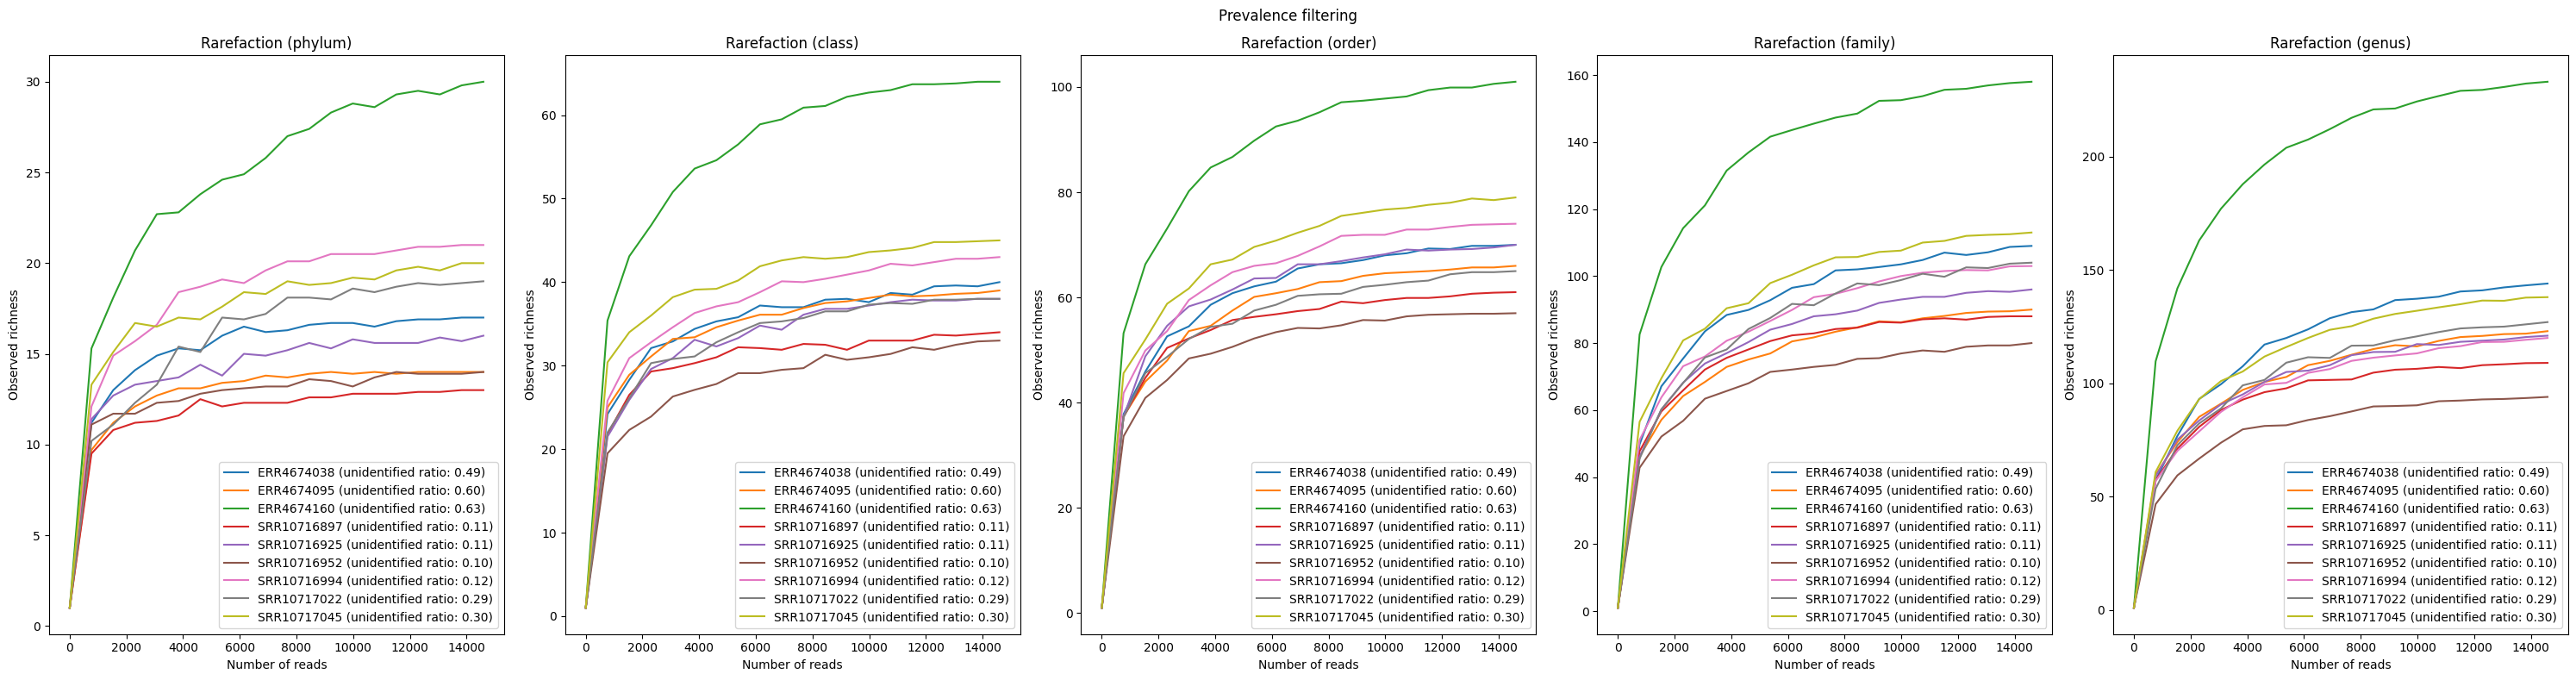

In [70]:
## PROKARYOTES ##
sample_list = samples_meta[samples_meta['sample_type']=='prok']['id'].tolist()  # this is sample list
data_list = analysis_meta[analysis_meta['relationships.sample.data.id'].isin(sample_list)]['relationships.run.data.id'].tolist()

# in this case it is correct, aggregate 
dropna = False   # setting for aggregation
tax_levels = ['phylum', 'class', 'order', 'family', 'genus']

# filter long_df_indexed to keep only prokaryotic samples
long_df_filt_inp = long_df_indexed[long_df_indexed.index.isin(data_list)]

rarefied_tables = {}
min_depth = 1e9
# first pass to determine min depth
for tax in tax_levels:
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(df_filt_pivot, percent=0.005, skip_columns=0)
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
    min_depth = min(min_depth, df_filt_pivot.sum().min())

print("Minimum depth after rarefaction:", min_depth)

# now run again with fixed depth
fig, axes = plt.subplots(1, len(tax_levels), figsize=(6 * len(tax_levels), 8))
rarefied_tables['prok'] = {}
for ax, tax in zip(axes, tax_levels):
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(
        df_filt_pivot,
        percent=0.01,
        skip_columns=0,
        verbose=False,
    )
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=min_depth)
    rarefied_tables['prok'][tax] = df_filt_pivot

    # rarefaction
    print(f"Plotting rarefaction for {tax}, shape {df_filt_pivot.shape} samples")
    plot_rarefaction_mgnify(
        df_filt_pivot,
        analysis_meta,
        every_nth=20,
        ax=ax,
        title=f'Rarefaction ({tax})',
    )

plt.suptitle("Prevalence filtering")
plt.tight_layout()

# save_plot_with_metadata(
#     fig,
#     filename='rarefaction_prok.png',
#     description='Rarefaction curves per taxonomic level',
#     out_dir=OUT_FOLDER,
# )

In [40]:
rarefied_tables.keys()

dict_keys(['prok'])

Taxonomic level: phylum
  Shape: (84, 165)
  Total counts per sample (min, max, mean): 0.0, 14591.0, 14502.57
  Total counts per feature (min, max, mean): 0.0, 1167030.0, 28487.19
  Number of features with non-zero counts: 83
Taxonomic level: class
  Shape: (161, 165)
  Total counts per sample (min, max, mean): 0.0, 14591.0, 14502.57
  Total counts per feature (min, max, mean): 0.0, 801886.0, 14862.88
  Number of features with non-zero counts: 160
Taxonomic level: order
  Shape: (297, 165)
  Total counts per sample (min, max, mean): 0.0, 14591.0, 14502.57
  Total counts per feature (min, max, mean): 1.0, 570478.0, 8056.98
  Number of features with non-zero counts: 297
Taxonomic level: family
  Shape: (575, 165)
  Total counts per sample (min, max, mean): 0.0, 14591.0, 14502.57
  Total counts per feature (min, max, mean): 0.0, 450322.0, 4161.61
  Number of features with non-zero counts: 569
Taxonomic level: genus
  Shape: (1137, 165)
  Total counts per sample (min, max, mean): 0.0, 1459

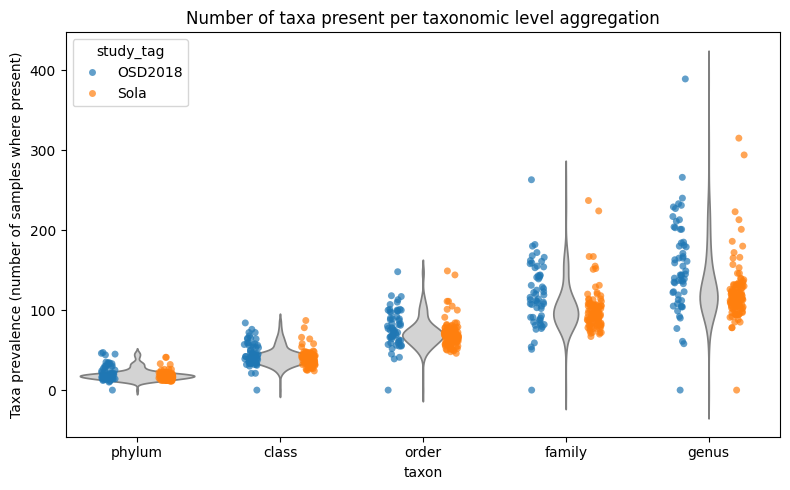

In [71]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 5))
for k, v in rarefied_tables.items():
    # Collect data for combined plotting
    combined, comb_arch, comb_bact, comb_euk = [], [], [], []
    for dic  in v.items():
        tax, table = dic
        print(f"Taxonomic level: {tax}")
        print(f"  Shape: {table.shape}")
        print(f"  Total counts per sample (min, max, mean): {table.sum(axis=0).min()}, {table.sum(axis=0).max()}, {table.sum(axis=0).mean():.2f}")
        print(f"  Total counts per feature (min, max, mean): {table.sum(axis=1).min()}, {table.sum(axis=1).max()}, {table.sum(axis=1).mean():.2f}")
        print(f"  Number of features with non-zero counts: {(table.sum(axis=1) > 0).sum()}")
        
        df = table > 0
        combined.append(df.sum().reset_index().assign(tax=tax))

        # granular
        df1 = df[df.index.str.contains('sk__Archaea')]
        df2 = df[df.index.str.contains('sk__Bacteria')]
        df3 = df[df.index.str.contains('sk__Eukaryota')]

        comb_arch.append(df1.sum().reset_index().assign(tax=tax))
        comb_bact.append(df2.sum().reset_index().assign(tax=tax))
        comb_euk.append(df3.sum().reset_index().assign(tax=tax))

    df_all = pd.concat(combined, ignore_index=True)
    df_all.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)
    df_all = df_all.merge(
        analysis_meta[['relationships.study.data.id', 'relationships.run.data.id', 'study_tag']],
        left_on='index',
        right_on='relationships.run.data.id',
        how='left'
    )

    df_arch = pd.concat(comb_arch, ignore_index=True)
    df_arch.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    df_bact = pd.concat(comb_bact, ignore_index=True)
    df_bact.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    df_euk = pd.concat(comb_euk, ignore_index=True)
    df_euk.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    # Draw violins (gray background)
    sns.violinplot(
        data=df_all,
        x="taxon", y="counts",
        inner=None, color="lightgray",
        ax=ax
    )

    # Add colored points per independent factor (region)
    # add points, but only assign a label if it's not already present to avoid duplicates
    sns.stripplot(
        data=df_all,
        x="taxon", y="counts",
        dodge=True,
        hue='study_tag',
        jitter=True, alpha=0.7,
        ax=ax
    )


# Beautify
ax.set_title(f"Number of taxa present per taxonomic level aggregation")
ax.set_ylabel("Taxa prevalence (number of samples where present)")
plt.tight_layout()


# save_plot_with_metadata(
#     fig,
#     filename='violin_n_per_taxon.png',
#     description='Number of taxa per sample to compare Euk and Prok',
#     out_dir=OUT_FOLDER,
# )

In [72]:
# df_arch['counts'].describe(), df_bact['counts'].describe(), df_euk['counts'].describe()

### Rarefaction per factor (season as an example)

filtered table shape: (905, 165)
subset table shape: (394, 40)
Plotting rarefaction for family in Spring with 40 samples
subset table shape: (394, 61)
Plotting rarefaction for family in Summer with 61 samples
subset table shape: (394, 18)
Plotting rarefaction for family in Autumn with 18 samples
subset table shape: (394, 46)
Plotting rarefaction for family in Winter with 46 samples
Saved PNG: /home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_prevalence-10.png_20251021_134004.png
Saved PDF: /home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_prevalence-10.png_20251021_134004.pdf
Metadata saved: /home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_prevalence-10.png_20251021_134004_metadata.json
Description saved: /home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_preval

{'saved_files': {'png': '/home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_prevalence-10.png_20251021_134004.png',
  'pdf': '/home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_prevalence-10.png_20251021_134004.pdf'},
 'metadata_file': '/home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_prevalence-10.png_20251021_134004_metadata.json',
 'description_file': '/home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_20251021_1216/rarefaction_season_prevalence-10.png_20251021_134004_description.txt',
 'base_name': 'rarefaction_season_prevalence-10.png_20251021_134004'}

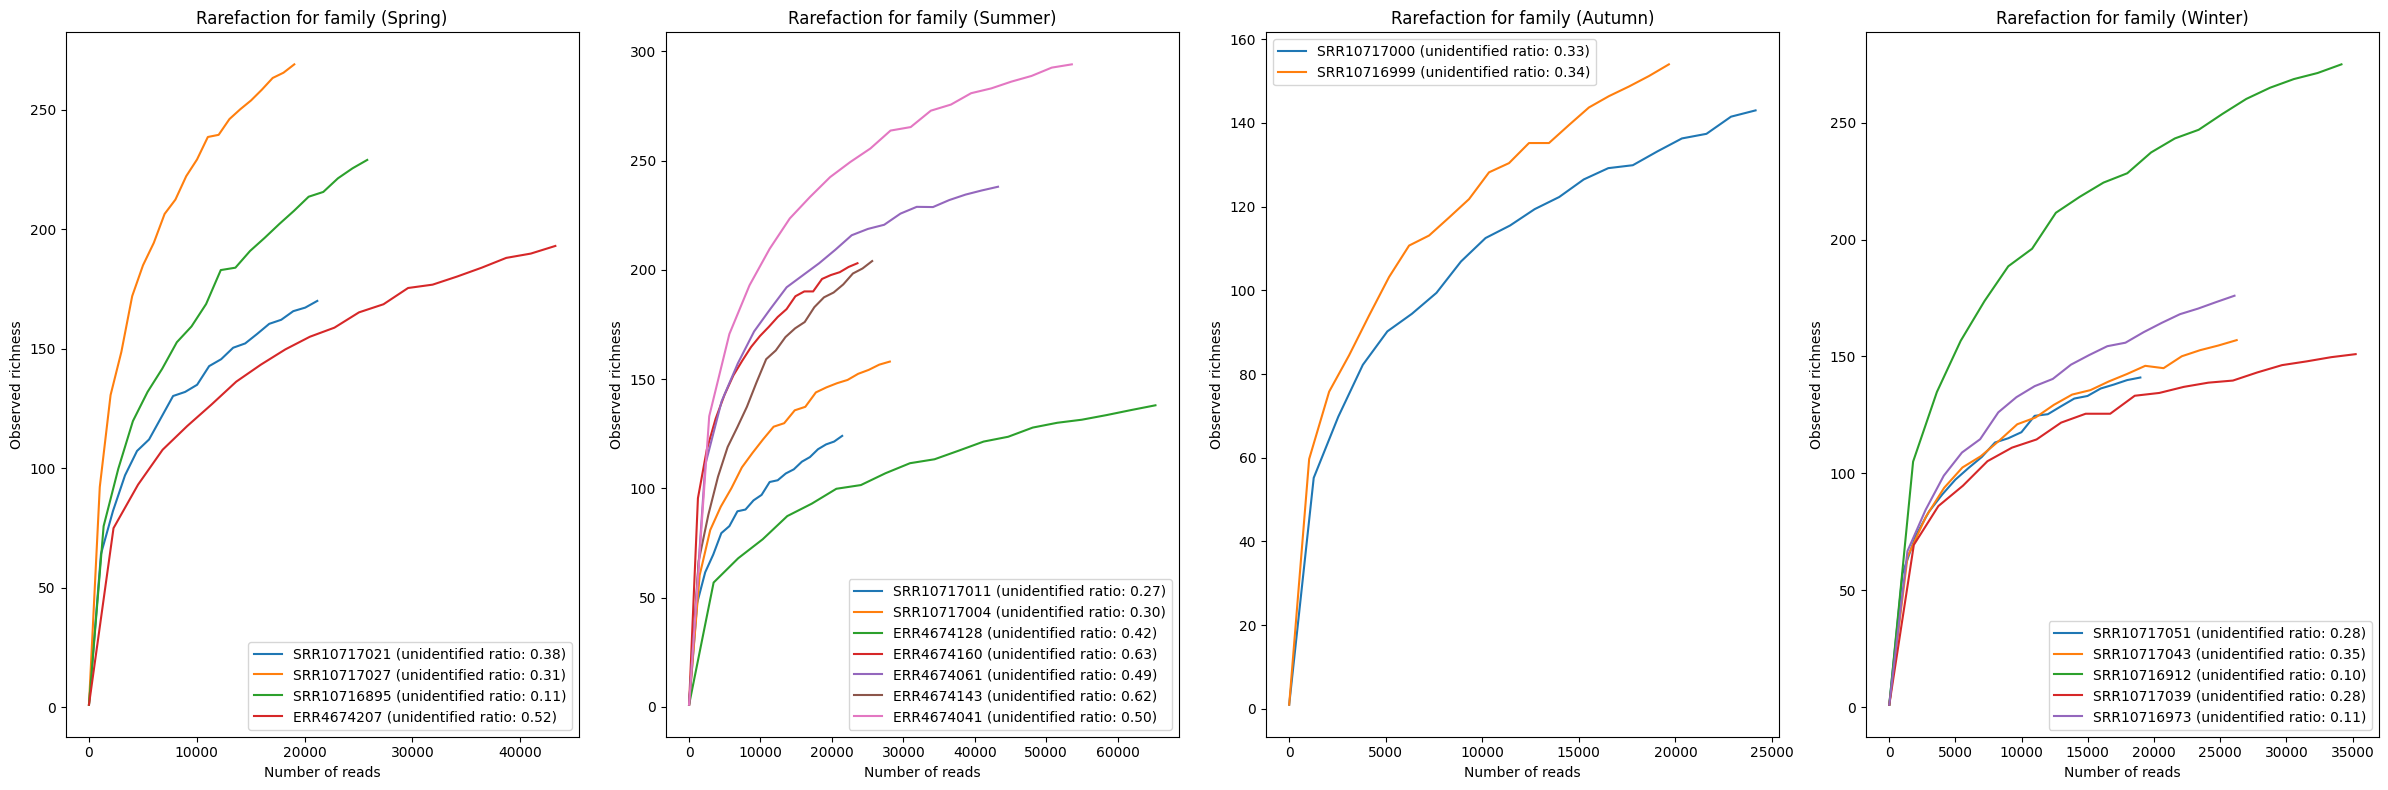

In [68]:
## Version 2, prevalence and rarefaction before the split
dropna = False   # setting for aggregation
tax_level = 'family'

fig, axes = plt.subplots(
    1, len(total_dict.items()),
    figsize=(6 * len(total_dict.items()), 8),
)

long_df_filt = aggregate_by_taxonomic_level(long_df_indexed, level=tax_level, dropna=dropna)
df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back
print('filtered table shape:', df_filt_pivot.shape)

# preprocess, shared names in order to uncomment
df_filt_pivot = prevalence_cutoff(df_filt_pivot, percent=10, skip_columns=0)
# df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
# assert df_filt_pivot.sum().describe()['std']==0, "Rarerfaction failed, sample sums are not equal"

rarefied_tables = {}
for ax, season_dict in zip(axes, total_dict.items()):
    season, v = season_dict
    sample_subset = list(total_dict[season].keys())
    df_subset = df_filt_pivot[sample_subset]
    print('subset table shape:', df_subset.shape)

    # rarefaction
    print(f"Plotting rarefaction for {tax_level} in {season} with {len(sample_subset)} samples")
    plot_rarefaction_mgnify(
        df_subset,
        analysis_meta,
        every_nth=10,
        ax=ax,
        title=f'Rarefaction for {tax_level} ({season})',
    )
    rarefied_tables[season] = df_subset
plt.tight_layout()
# plt.savefig(os.path.join(OUT_FOLDER, 'rarefaction_season_prevalence-10.png'))


save_plot_with_metadata(
    fig,
    filename='rarefaction_season_prevalence-10.png',
    description='Rarefaction curves per season Euk and Prok mixed',
    out_dir=OUT_FOLDER,
)

Taxonomic level: Spring
  Shape: (394, 40)
  Total counts per sample (min, max, mean): 14637, 49544, 30513.70
  Total counts per feature (min, max, mean): 1, 243577, 3097.84
  Number of features with non-zero counts: 394
Taxonomic level: Summer
  Shape: (394, 61)
  Total counts per sample (min, max, mean): 13673, 70810, 38105.54
  Total counts per feature (min, max, mean): 0, 449230, 5899.59
  Number of features with non-zero counts: 390
Taxonomic level: Autumn
  Shape: (394, 18)
  Total counts per sample (min, max, mean): 19661, 36028, 28262.83
  Total counts per feature (min, max, mean): 0, 105463, 1291.20
  Number of features with non-zero counts: 357
Taxonomic level: Winter
  Shape: (394, 46)
  Total counts per sample (min, max, mean): 17880, 35976, 27596.00
  Total counts per feature (min, max, mean): 0, 247329, 3221.87
  Number of features with non-zero counts: 387


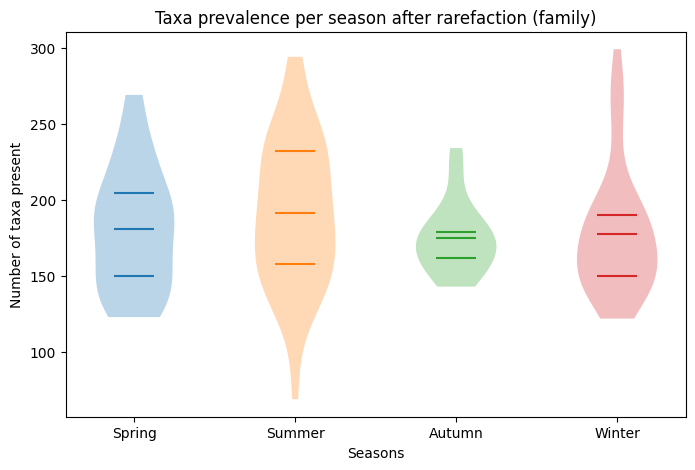

In [69]:
# Calculate stats on the rarefied tables
fig, ax = plt.subplots(figsize=(8, 5))

pos = 1
labels = []
for dic  in rarefied_tables.items():
    tax, table = dic
    print(f"Taxonomic level: {tax}")
    print(f"  Shape: {table.shape}")
    print(f"  Total counts per sample (min, max, mean): {table.sum(axis=0).min()}, {table.sum(axis=0).max()}, {table.sum(axis=0).mean():.2f}")
    print(f"  Total counts per feature (min, max, mean): {table.sum(axis=1).min()}, {table.sum(axis=1).max()}, {table.sum(axis=1).mean():.2f}")
    print(f"  Number of features with non-zero counts: {(table.sum(axis=1) > 0).sum()}")
    
    df = table > 0
    ax.violinplot(
        df.sum(), showmeans=True, positions=[pos],
        showextrema=False,
        quantiles=[[0.25, 0.75]],)
    pos += 1
    labels.append(tax)

ax.set_xticks(range(1, pos))
ax.set_xticklabels(labels)
ax.set_title(f"Taxa prevalence per season after rarefaction ({tax_level})")
ax.set_xlabel("Seasons")
ax.set_ylabel("Number of taxa present")
plt.savefig(os.path.join(OUT_FOLDER, 'taxa_number_season_prev-10.png'))
plt.show()

## EMO-BON
- here again taking simply number of reads mapped, not the total reads
- should be scaled by the total reads?

In [ ]:
emobon_folder = os.path.abspath(os.path.join('../../data'))
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(emobon_folder, 'shipment_b1b2_181.csv')
    )
    return df_valid

valid_samples = get_valid_samples()

In [ ]:
# High level function from the momics.utils module
full_metadata, mgf_parquet_dfs = load_and_clean(valid_samples=valid_samples)

In [ ]:
# keep only taxonomy
ssu = mgf_parquet_dfs['ssu'].copy()
lsu = mgf_parquet_dfs['lsu'].copy()

del mgf_parquet_dfs

In [ ]:
def process_taxonomy(df, TAXONOMY_RANKS):
    df_filt = fill_taxonomy_placeholders(df, TAXONOMY_RANKS)
    df_filt = pivot_taxonomic_data(df_filt)


# unify taxonomic information to the MGnify
    df_filt = df_filt.reset_index()
    df_filt['taxonomic_concat'] = df_filt['taxonomic_concat'].apply(clean_tax_row)

# unify column and index names
    df_filt = df_filt.set_index('ncbi_tax_id')
    df_filt = df_filt.rename(columns={
    'taxonomic_concat': '#SampleID',
})
    df_filt.rename(columns={'#SampleID': 'taxonomy'}, inplace=True)
    df_filt.set_index('taxonomy', inplace=True)
    df_filt.head()
    return df_filt

ssu_filt = process_taxonomy(ssu, TAXONOMY_RANKS)
lsu_filt = process_taxonomy(lsu, TAXONOMY_RANKS)
ssu_filt.head()

In [ ]:
abund_emobon = ssu_filt.copy()

for sample in abund_emobon.columns[:5]:
    reads = np.repeat(abund_emobon.index, abund_emobon[sample].values)
    depths, richness = rarefaction_curve(reads)
    plt.plot(depths, richness, label=sample)

plt.legend()
plt.xlabel("Number of reads")
plt.ylabel("Observed richness")
plt.title("Rarefaction curves per sample")
plt.show()